Has plot? True


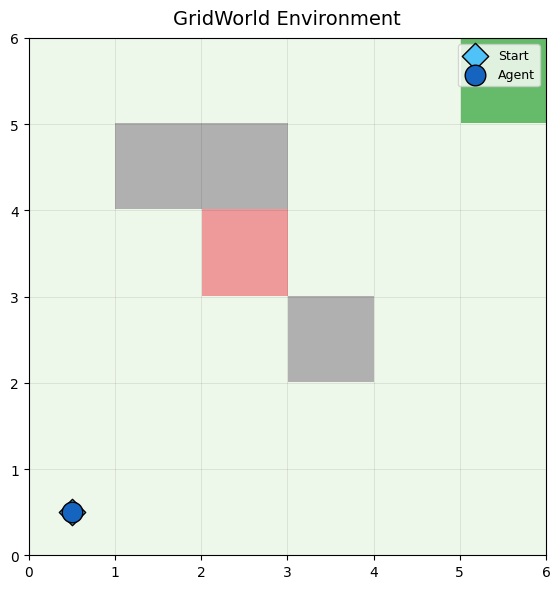

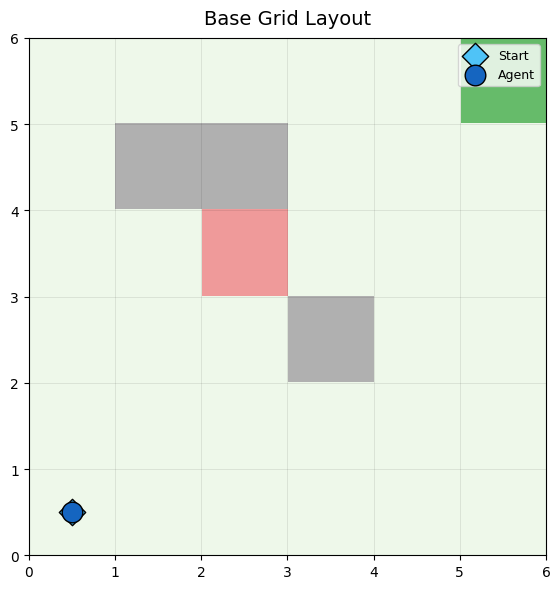

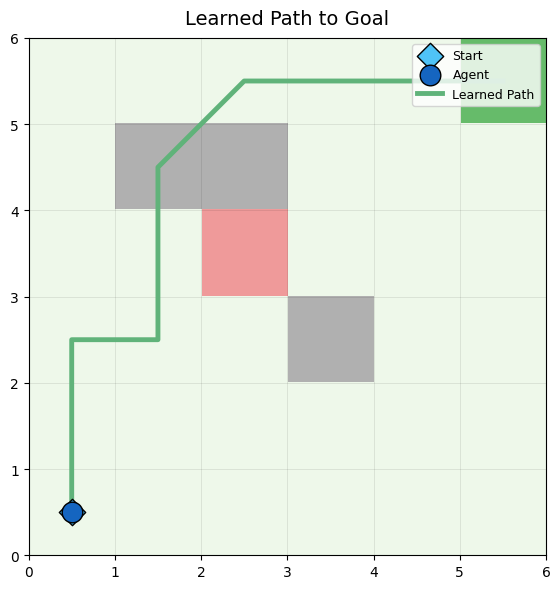

In [8]:
# RUN THIS: 
# This setup is important so every notebook knows where to find 'rl_capstone'

# ---- Setup ---- #
import sys, os
sys.path.append(os.path.abspath("../src"))

# ---- Reload to avoid stale imports ----
import importlib, rl_capstone.gridworld
importlib.reload(rl_capstone.gridworld)

# ---- Import fresh classes ----
from rl_capstone.gridworld import GridWorld, WorldSettings
print("Has plot?", hasattr(GridWorld, "plot"))




# # ---- Imports ---- #
# from rl_capstone.gridworld import GridWorld, WorldSettings
# # from rl_capstone.rl_algorithms import q_learning
# # from rl_capstone.utils import epsilon_greedy

# ---- Quick Test ---- #
env = GridWorld(WorldSettings())
env.plot()


# Create environment
settings = WorldSettings()
env = GridWorld(settings)

# Just visualize the map
env.plot(title="Base Grid Layout")

# Visualize with agent path
example_path = [(5,0), (4,0), (3,0), (3,1), (2,1), (1,1), (0,2), (0,3), (0,4), (0,5)]
env.plot(path=example_path, title="Learned Path to Goal")
